### Bigram model
- Bigram (one character predicts the next one with a lookup table of counts)

In [4]:
import random
with open("names.txt", "r+") as f:
	words = f.read().splitlines()
	words = [word.strip() for word in words] # get rid of any trailing spaces
	words = [w for w in words if w] # get rid of any empty strings
	names = sorted(words, key=lambda x: random.random())
	
with open("names.txt", "w") as f: 
	joined = "\n".join(names)
	f.write(joined)
min_chars = 1
max_chars = max(len(v) for v in names)
chars = sorted(['.'] + list(set("".join(names))))

# in replacement of the start and end token. Every name should start and end with a period
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

# adding start and end token to each name
# names = [['<S>'] + list(name) + ['<E>'] for name in names]

names = [['.'] + list(name) + ['.'] for name in names]


names:  ['reeves', 'harbour', 'verity', 'brettley', 'pinchas']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 1)


In [5]:
b = {}
for name in names:
	for ch1, ch2 in zip(name, name[1:]):
		bigram = (ch1, ch2)
		b[bigram] = b.get(bigram, 0) + 1

b = sorted(b.items(), key = lambda kv: -kv[1])
print("max bigram occurance: ", b[0])
print("min bigram occurance: ", b[-1])
b = dict(b)

max bigram occurance:  (('n', '.'), 6763)
min bigram occurance:  (('g', 'f'), 1)


In [6]:
import torch
# N = np.array([])

# a replacement until pytorch starts to work again
# for i in range(28):
#     N.append([])
#     for j in range(28):
#         N[i].append(1) # for smoothening the array
# assert len(N) == 28
# assert len(N[0]) == 28

N = torch.zeros((chars_count, chars_count), dtype=torch.int32)

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

for name in names:
	for ch1, ch2 in zip(name, name[1:]):
		ix1, ix2 = atoi[ch1], atoi[ch2]
		N[ix1,ix2] += 1

print(N.size())


torch.Size([27, 27])


size:  torch.Size([27, 27])


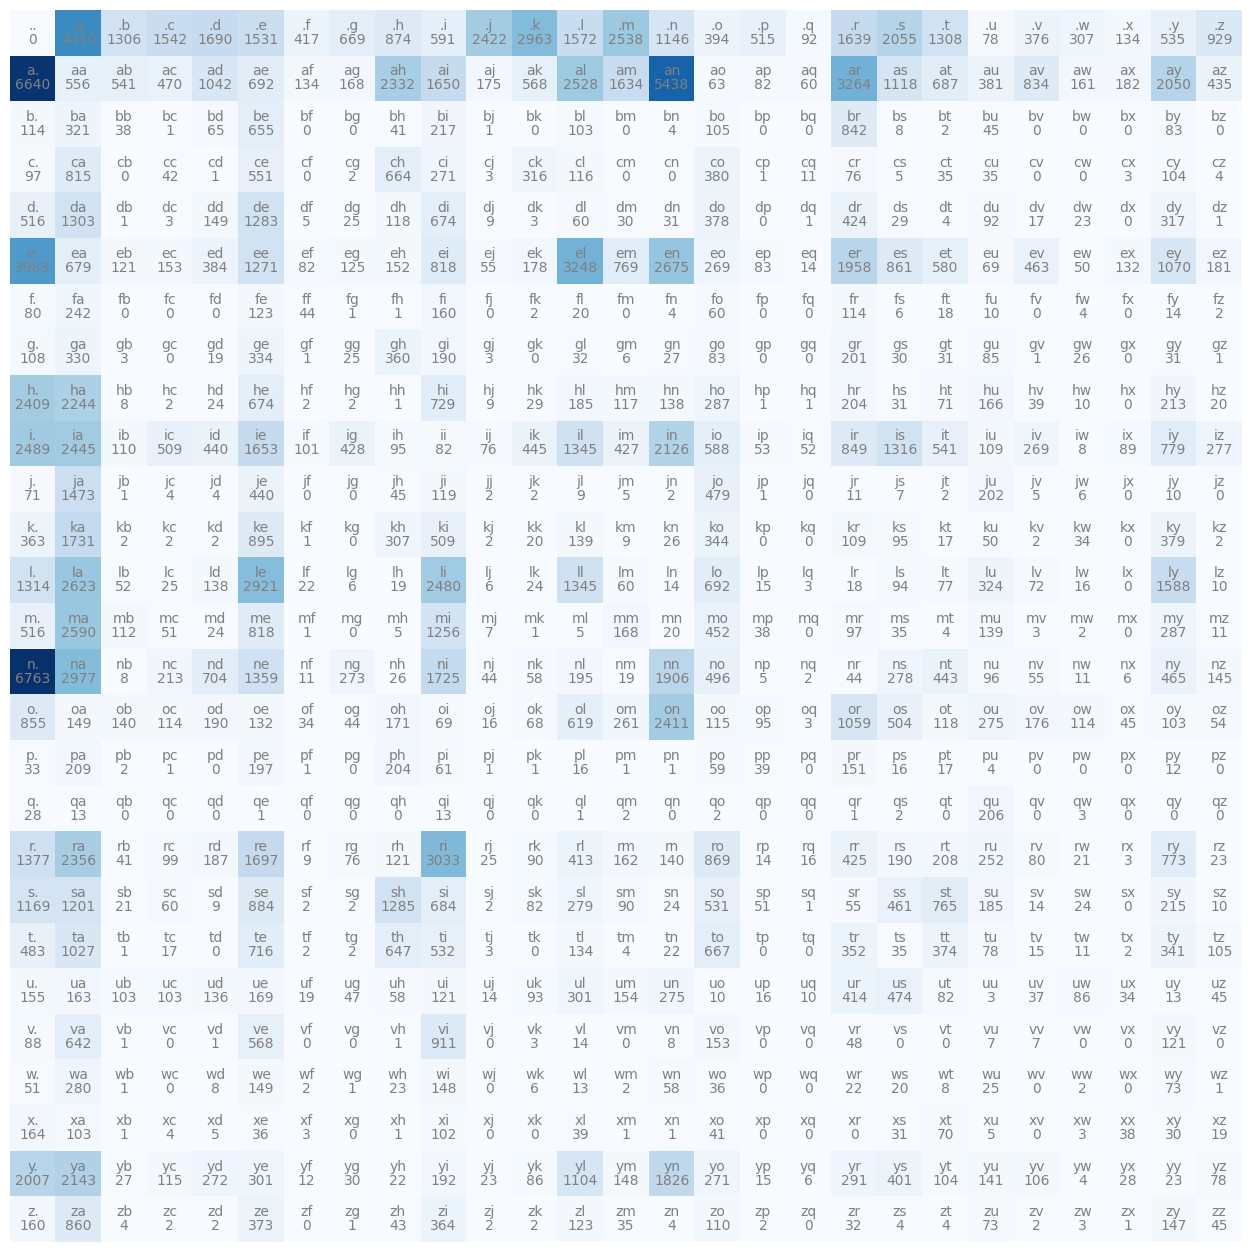

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# visualization
def visualize(S, size=chars_count, dtype="int", skip=[]):
    plt.figure(figsize=(16,16))
    print("size: ", S.size())
    plt.imshow(S, cmap='Blues')

    for i in range(size):
        for j in range(size):
            chstr = itoa[i ] + itoa[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
            if dtype=="float":
                plt.text(j, i, f"{S[i,j].item():.3f}", ha="center", va="top", color='gray')
            else:
               plt.text(j, i, f"{S[i,j].item()}", ha="center", va="top", color='gray')

    
    plt.axis('off');

visualize(N)

In [ ]:
# since <E> cannot begin a statement, and <S> can not end a statement.

# N_pop = torch.cat((N[:1], N[2:])) # pop second row
# N_pop = N_pop[:, 1:] # remove first column
# N_pop[:5], N_pop.size()

In [8]:
# Normalization of N
# import numpy as np
# P = np.array(N, dtype=np.float64)
# print(len(P[0]), len(P))
# print(P.size, P[0].size)
# for i in range(28):
#     s = P[i].sum()
#     P[i] = P[i] / s

P = (N+1).float()
P /= P.sum(1, keepdims=True) # normalization along the horizontal
print(P[0].sum(), P.size())

# normalization test
for i in range(27):
    assert P[i].sum() < 1.001 and P[i].sum() > 0.99, "print " + str(P[i].sum())

tensor(1.) torch.Size([27, 27])


size:  torch.Size([27, 27]) 27


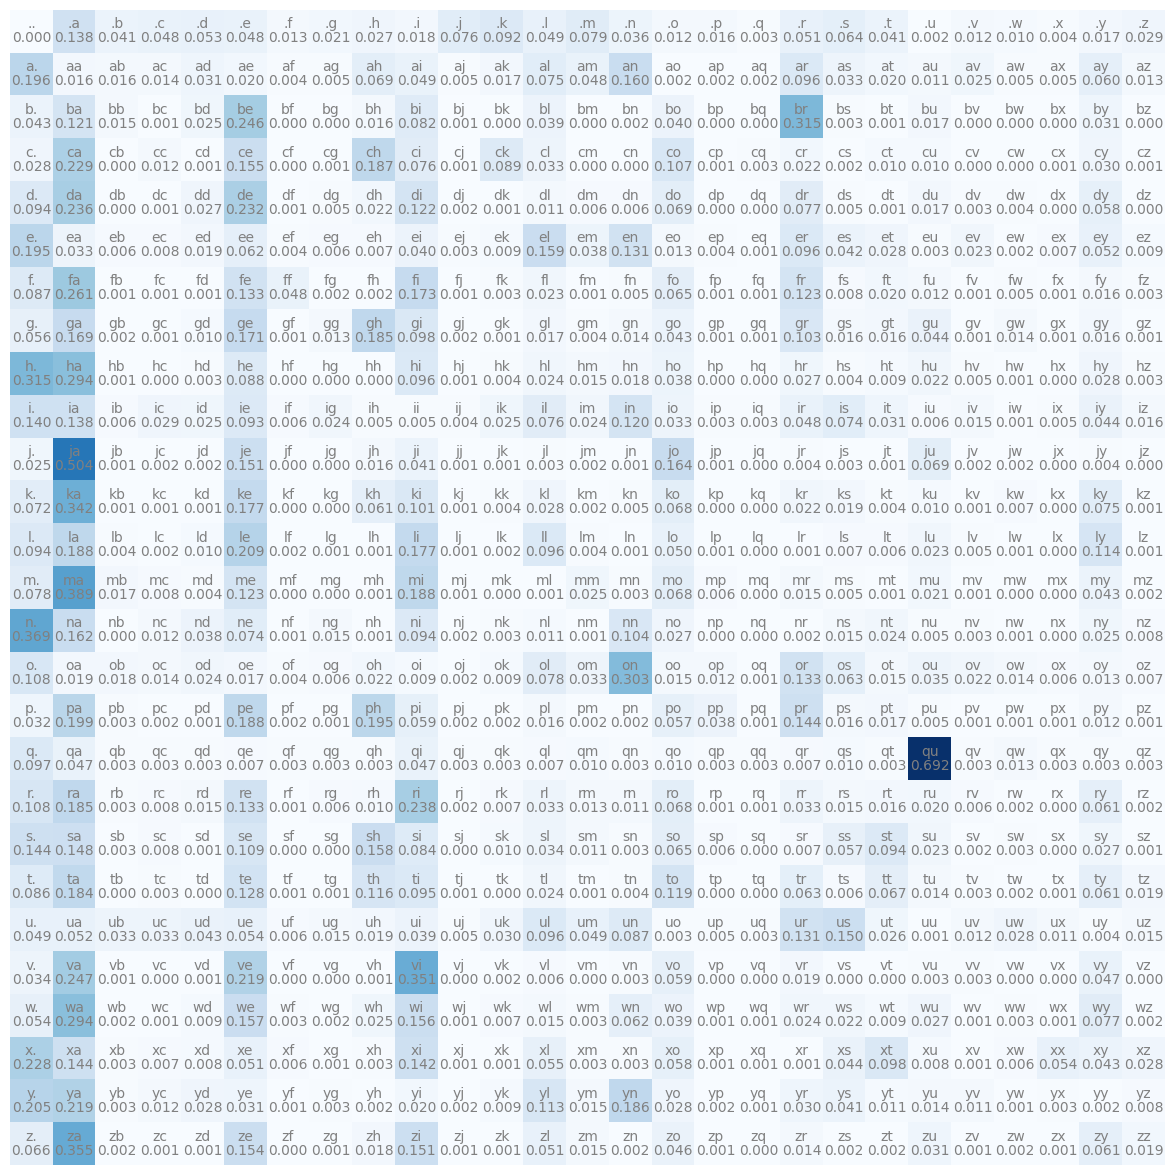

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))
print("size: ", P.size(), len(P))
plt.imshow(P, cmap='Blues')

# Show the plot

size = 27
for i in range(size):
    ix = i
    # if i > 0:
    #     ix = i + 1
    for j in range(size):
        # iy = j + 1
        iy = j
        chstr = itoa[ix] + itoa[iy]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f"{P[i,j].item():.3f}", ha="center", va="top", color='gray')

plt.axis('off');
plt.show()


In [10]:
# negative log likelihood
def nnl(name):
  name = ['.'] + list(name) + ['.']
  n = 0
  log = torch.tensor(0, dtype=torch.float64)
  for ch1, ch2 in zip(name, name[1:]):
    ix1, ix2 = atoi[ch1], atoi[ch2]
    log += torch.log(P[ix1,ix2])
    n+=1
  log = -log
  return log/n

nnl("janan")

    

tensor(1.6243, dtype=torch.float64)

In [11]:
g = torch.Generator().manual_seed(2147483647)

generated_names = []
print("generating...")
while True:
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoa[ix])
        if ix == 0:
            break
    out.pop()
    word = ''.join(out)
    # streamlining results
    if nnl(word) < 1.7 and len(word) > 3 and word not in generated_names:
        print("+ valid word: ", word)
        generated_names.append(word) 
    if len(generated_names) == 10:
        break
# generated_names

with open("generated.txt", "w") as f: 
	joined = "\n".join(generated_names)
	f.write(joined)


    

generating...
+ valid word:  jann
+ valid word:  anan
+ valid word:  jaman
+ valid word:  jahan
+ valid word:  janan
+ valid word:  jaran
+ valid word:  kanan
+ valid word:  manan
+ valid word:  kahan
+ valid word:  jarin


In [12]:
n = 0
nnls = torch.tensor(0, dtype=torch.float64)
for name in names:
    name = name[1:-1]
    x = nnl(name)
    nnls += x
    n+=1
print("nnl of the entire dataset is", (nnls/n).item())
    

nnl of the entire dataset is 2.460574555642786


### NN
- Using neural network to arrive at the same result

In [13]:
# create the training set of bigrams (x,y)
train, val = [], []

for name in names:
  for ch1, ch2 in zip(name, name[1:]):
    ix1 = atoi[ch1]
    ix2 = atoi[ch2]
    train.append(ix1)
    val.append(ix2)
# train = train[:5]
# val = val[:5]
train = torch.tensor(train)
val = torch.tensor(val)
val, train

(tensor([18,  5,  5,  ...,  5,  5,  0]),
 tensor([ 0, 18,  5,  ..., 18,  5,  5]))

In [14]:
import torch.nn.functional as F
xenc = F.one_hot(train, num_classes=27).float()
print(xenc.size())

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

logits =  xenc @ W # log-counts
print(logits.size())

# applying softmax
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdim=True) 
probs.size()

torch.Size([228146, 27])
torch.Size([228146, 27])


torch.Size([228146, 27])

In [15]:
# measuring the mean negative log likelihood
n = len(train)
for i in range(10):
    x = train[i].item() # input character index
    y = val[i].item() # label character index
    print(f"for {itoa[x]}, the answer is {itoa[y]}, with prob: {probs[i][y]:.3f}", )
    

for ., the answer is r, with prob: 0.025
for r, the answer is e, with prob: 0.029
for e, the answer is e, with prob: 0.029
for e, the answer is v, with prob: 0.050
for v, the answer is e, with prob: 0.005
for e, the answer is s, with prob: 0.021
for s, the answer is ., with prob: 0.010
for ., the answer is h, with prob: 0.014
for h, the answer is a, with prob: 0.020
for a, the answer is r, with prob: 0.090


In [16]:
loss = -probs[torch.arange(n), val].log().mean()
print("nnl of the entire dataset is", loss.item())

nnl of the entire dataset is 3.758953332901001


In [17]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

# gradient descent
while True:

    if loss < 2.49:
        break
    # forward pass
    xenc = F.one_hot(train, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(n), val].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

  
  # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
  
  # update
    W.data += -50 * W.grad

3.768618583679199
3.378804922103882
3.1610896587371826
3.027186155319214
2.9344847202301025
2.867231845855713
2.816654920578003
2.777147054672241
2.7452545166015625
2.7188310623168945
2.696505546569824
2.677372694015503
2.6608052253723145
2.6463515758514404
2.633665084838867
2.622471570968628
2.6125476360321045
2.6037065982818604
2.595794439315796
2.5886809825897217
2.5822560787200928
2.576429843902588
2.5711233615875244
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539438724517822
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413522720336914
2.538721799850464
2.536262035369873
2.5339579582214355
2.531797409057617
2.529768228530884
2.527859926223755
2.526063919067383
2.5243709087371826
2.522773265838623
2.52126407623291
2.519836664199829
2.5184855461120605
2.5172057151794434
2.5159904956817627
2.5148372650146484
2.5137410163879395
2.512697696685791
2.511704921722412
2.5107579231262207
2.509854555130005
2.5089924335479736
2.5081682205200195
2.507380247116089
2.

In [18]:
# GENERATE FROM THE 'NEURAL NET' MODEL
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoa[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.


In [19]:
g = torch.Generator().manual_seed(2147483647)

generated_names = []
print("generating...")
while True:
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoa[ix])
        if ix == 0:
            break
    out.pop()
    word = ''.join(out)
    # streamlining results
    if nnl(word) < 1.7 and len(word) > 3 and word not in generated_names:
        print("+ valid word: ", word)
        generated_names.append(word) 
    if len(generated_names) == 10:
        break

generating...
+ valid word:  jann
+ valid word:  anan
+ valid word:  jaman
+ valid word:  jahan
+ valid word:  janan
+ valid word:  jaran
+ valid word:  kanan
+ valid word:  manan
+ valid word:  kahan
+ valid word:  jarin


In [ ]:
xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
p = counts / counts.sum(1, keepdims=True) # probabilities for next character
plt.scatter()
